In [2]:
import pandas as pd
import talib
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
from mplfinance.original_flavor import candlestick_ohlc
from tqdm import tqdm

In [19]:
data_df = pd.read_csv('data/XBTUSD-1h-data.csv')

In [4]:
print(data_df['timestamp'])

0        2017-06-01 00:00:00+00:00
1        2017-06-01 01:00:00+00:00
2        2017-06-01 02:00:00+00:00
3        2017-06-01 03:00:00+00:00
4        2017-06-01 04:00:00+00:00
                   ...            
32957    2021-03-05 05:00:00+00:00
32958    2021-03-05 06:00:00+00:00
32959    2021-03-05 07:00:00+00:00
32960    2021-03-05 08:00:00+00:00
32961    2021-03-05 09:00:00+00:00
Name: timestamp, Length: 32962, dtype: object


In [ ]:
def transform_candle(data, ratio):
    """
    convert from small candle size to large candle size.
    :param data: data frame of small candle
    :param ratio: ratio = large_candle_size/small_candle_size. Ex, 5m => 1d, ratio = 1440/5 = 288. Must be int type
    :return: new data frame of large candle size
    """
    if type(ratio) is not int:
        raise Exception('ratio is not valid type. Need to {int} type')
    # if ratio == 1:
    #     return data
    converted_data = []
    if data.shape[0] >= ratio:
        for i in range(0, data.shape[0] - (ratio - 1), ratio):
            high = data[i:i + ratio]['high'].max()
            low = data[i:i + ratio]['low'].min()
            # volume = data[i:i + ratio]['volume'].sum()
            converted_data.append({
                'timestamp': data.iloc[i + (ratio - 1)]['timestamp'],
                'open': data.iloc[i]['open'],
                'high': high,
                'low': low,
                'close': data.iloc[i + (ratio - 1)]['close'],
                # 'volume': volume
            })
    else:
        raise Exception('Too few small candles')
    return pd.DataFrame(converted_data)

In [5]:
def find_best_ma(data, max_ema=200):
    loss = float('inf')
    ema_no = max_ema
    rate = 1
    value = None
    for i in range(10, max_ema+1):
        ema = talib.EMA(data['close'], timeperiod=i) # it start index from 3, dont know why
        ema_df = pd.DataFrame({"ema": ema}).reset_index()
        joined_data = data.join(ema_df["ema"])
        #         high_d = joined_data[joined_data['high'] >= joined_data['ema']]
        #         low_d = joined_data[joined_data['low'] ]
        medium_d = joined_data[
            (joined_data['high'] >= joined_data['ema']) & (joined_data['low'] <= joined_data['ema'])]
        cross_short_df = medium_d[(medium_d['open'] > medium_d['ema']) & (medium_d['close'] < medium_d['ema'])]
        cross_long_df = medium_d[(medium_d['close'] > medium_d['ema']) & (medium_d['open'] < medium_d['ema'])]
        temp_loss = abs((joined_data['low'] - joined_data['ema']).sum())
        temp_rate = (cross_long_df.shape[0] + cross_short_df.shape[0]) / data.shape[0]
        loss = min(loss, temp_loss)
        if loss == temp_loss:
            ema_no = i
            rate = temp_rate
            value = ema_df['ema']
    return {'number': ema_no, 'rate': rate, 'value': value, 'loss': loss}

In [108]:
%%time
find_best_ma(data_df[400:800])

CPU times: user 1.19 s, sys: 9.97 ms, total: 1.2 s
Wall time: 1.3 s


{'number': 200,
 'rate': 0.0,
 'value': 0              NaN
 1              NaN
 2              NaN
 3              NaN
 4              NaN
           ...     
 395    2514.162035
 396    2515.177338
 397    2516.221345
 398    2517.302724
 399    2518.396230
 Name: ema, Length: 400, dtype: float64,
 'loss': 0.0}

In [6]:
%%time

def optimized_ema(data, window=200, delta=1):
    # params
    number = window
    number_series = []
    value_series = []
    rate_series = []
    for index in tqdm(range (0, data.shape[0], delta)):
        if window <= index <= data.shape[0] - window:
            temp_data = data[index - window: index + window]
            best_ema = find_best_ma(temp_data, window)
            if number != best_ema['number']:
                number = best_ema['number']
            if len(value_series) == 0:
                value_series = best_ema['value']
                rate_series = [best_ema['rate']] * len(best_ema['value'])
                number_series = [best_ema['number']] * len(best_ema['value'])
            else:
                new_value = best_ema['value'].iloc[-1] # get last value from best_ema
                new_value_series = pd.Series([new_value]*delta, index=[(value_series.index.max() + 1 + i) for i in range(0,delta)])
                value_series = value_series.append(new_value_series)
                rate_series.extend([best_ema['rate']]*delta)
                number_series.extend([best_ema['number']]*delta)
    return pd.DataFrame({'value': value_series, 'rate': rate_series, 'number': number_series})

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [ ]:
%%time
ema = optimized_ema(data_df, window=200, delta=24)

In [111]:
ema

,value,rate,number
0,NaN,0.0175,124
1,NaN,0.0175,124
2,NaN,0.0175,124
3,NaN,0.0175,124
4,NaN,0.0175,124
...,...,...,...
983,2466.39663,0.0000,200
984,2466.39663,0.0000,200
985,2466.39663,0.0000,200
986,2466.39663,0.0000,200


In [ ]:
ema[ema['rate'] <= 0.2]


,value,rate,number
0,NaN,0.0175,124
1,NaN,0.0175,124
2,NaN,0.0175,124
3,NaN,0.0175,124
4,NaN,0.0175,124
...,...,...,...
983,2466.39663,0.0000,200
984,2466.39663,0.0000,200
985,2466.39663,0.0000,200
986,2466.39663,0.0000,200


In [8]:
def run_strategy(data, best_ema):
    joined_data = data.join(best_ema)
    buy_condition = ((joined_data['value'] <= 0.995 * joined_data['open']) &
            (joined_data['value'] >= joined_data['low']) &
            (joined_data['rate'] <= 0.2))
    sell_condition = (joined_data['value'] >= joined_data['close'])
    joined_data.loc[buy_condition, 'buy'] = 1
    joined_data.loc[sell_condition, 'sell'] = 1
    return joined_data

In [9]:
strategy_data=run_strategy(data_df, ema)
strategy_data.to_csv('result/XBTUSD-1h-result.csv')

In [10]:
def performance_report(data):
    trade_history = []
    round_trip = []
    order = {}
    for index, row in data.iterrows():
        if row['buy'] == 1 and (len(trade_history) == 0 or trade_history[-1]['side'] != 'buy'):
            trade_history.append({'time': row['timestamp'],'side': 'buy', 'price': row['value']})
            order = {'start_time': row['timestamp'], 'entry': row['value'] }
        if row['sell'] == 1 and len(trade_history) != 0 and trade_history[-1]['side'] != 'sell':
            trade_history.append({'time': row['timestamp'],'side': 'sell', 'price': row['close']})
            order['end_time'] = row['timestamp']
            order['exit'] = row['close']
            order['profit'] = round(100* (order['exit'] - order['entry'])/order['entry'],2)
            round_trip.append(order)
            order = {}
    return pd.DataFrame(trade_history), pd.DataFrame(round_trip)

In [11]:
%%time
th, rt = performance_report(strategy_data)

CPU times: user 3.23 s, sys: 48 ms, total: 3.28 s
Wall time: 3.47 s


In [12]:
th.to_csv('result/trade-history.csv', index=False)
rt.to_csv('result/round-trip.csv', index=False)

In [13]:
strategy_data.to_csv('result.csv', index=False)

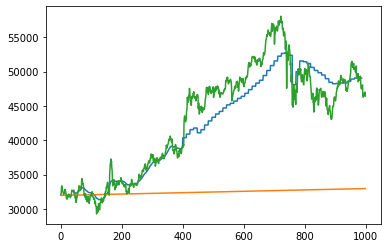

In [18]:
# EMA = run_strategy(data_df)
# print (EMA)
# ema = talib.EMA(data_df['close'], timeperiod=EMA)

plt.plot(ema['value'])
# plt.plot(data_df[-365:-1]['high'])
plt.plot(data_df['low'][-1000:].reset_index())
# plt.plot(data_df[-365:-1]['low'])
plt.show()

In [ ]:
# python_candlestick_chart.py

plt.style.use('ggplot')

# Extracting Data for plotting
ohlc = data_df.loc[:, ['timestamp', 'open', 'high', 'low', 'close']]
ema = ema.loc[:, ['value', 'rate', 'number']]
ohlc['timestamp'] = pd.to_datetime(ohlc['timestamp'])
ohlc['timestamp'] = ohlc['timestamp'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=5, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of XBTUSD')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()
plt.figure(figsize=(30, 40), dpi=200)

plt.show()


In [ ]:
def performance_report(data, order_df):
    total_profit = order_df['profit'].sum()
    max_dd = order_df['draw_down_percent'].min()
    max_ru = order_df['run_up_percent'].max()
    num_win = order_df[order_df.profit >= 0].count().profit
    num_loss = order_df[order_df.profit < 0].count().profit
    total_win_profit = order_df[order_df.profit >= 0].sum().profit
    total_loss_profit = order_df[order_df.profit < 0].sum().profit
    ave_win = total_win_profit / num_win if num_win != 0 else 0
    ave_loss = total_loss_profit / num_loss if num_loss != 0 else 0
    win_rate = num_win / (num_win + num_loss)
    start_price = data.iloc[100]['close']
    end_price = data.iloc[-1]['close']
    market = (end_price / start_price - 1) * 100
    start_balance = 100
    balance = start_balance * (1 + total_profit / 100)
    relative_profit = balance - start_balance
    relative_yearly_profit = relative_profit / 3
    sharpe = 10
    trades = order_df.shape[0] * 2

    return {'profit': float(total_profit), 'max_dd': float(max_dd), 'max_ru': float(max_ru),
            'num_win': int(num_win), 'num_loss': int(num_loss),
            'total_win_profit': int(total_win_profit),
            'total_loss_profit': int(total_loss_profit),
            'ave_win': float(ave_win), 'ave_loss': float(ave_loss),
            'win_rate': float(win_rate), 'balance': float(balance), 'startBalance': float(start_balance),
            'relativeYearlyProfit': float(relative_yearly_profit), 'market': float(market), 'sharpe': float(sharpe),
            'trades': int(trades), 'startPrice': start_price, 'endPrice': end_price, 'relativeProfit': relative_profit}

In [ ]:
## Start download-data
pairs = ['XBTUSD', 'ETHUSDT', 'DOTUSDT', 'EOSUSDT', 'ADAUSDT' ]
timeframes = ['1d']

In [ ]:
%%time
for pair in pairs:
    for t in timeframes:
        print ('Processing {p} with timeframe {t}'.format(p=pair, t=t))
        data_df = pd.read_csv("data/{p}-{t}-data.csv".format(p=pair, t=t))
        ema = optimized_ema(data_df, window=200, delta=7)
        strategy=run_strategy(data_df, ema)
        th, rt = performance_report(strategy)
        strategy.to_csv('result/{p}-{t}-strategy-data'.format(p=pair, t=t), index=False)
        th.to_csv('result/{p}-{t}-trade-history.csv'.format(p=pair, t=t), index=False)
        rt.to_csv('result/{p}-{t}-round-trip.csv'.format(p=pair, t=t), index=False)


In [ ]:
df = pd.DataFrame({'value': [1,2,3,4,5,6,7,8,9]})

In [ ]:
df[df['value'].shift(-1) == 5]